In [1]:
import pandas as pd
import numpy as np
import itertools
import random
import ast
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits import mplot3d
from scipy.spatial import distance
from pyxdameraulevenshtein import damerau_levenshtein_distance

pd.set_option('display.max_rows', 500)

In [2]:
df = pd.read_csv('all_task_environments.csv', header=0, skiprows=[1])

In [3]:
objects = ['t', 'n', 's', 'p', 'c']

coordinates = {'c': (1,4,4),
              'n': (1,1,2),
              'p': (1,4,4),
              's': (1,2,2),
              't': (1,1,2),
              'start': (2,1,2),
              'table': (4,3,2)}

c1 = {'c': 1.2,
    'n': 1.0,
    'p': 1.2,
    's': 1.2,
    't': 1.0}

k1 = {'c': 1.0,
    'n': 0.95,
    'p': 0.95,
    's': 1.0,
    't': 0.9}

start_coordinates = [[2,1.5,2],[4,3,2],[4,3,2],[4,3,2],[4,3,2]]

In [4]:
def predict_sequence(objects, coordinates, start_coordinates, c, k, dimension=[3,], steps=1):
    prediction = []
    possible_items = dict.fromkeys(objects, 0) # generate dict from object list
    coord_index = 0
    start_coords = start_coordinates
    coords = coordinates
    new_coords = {}
    new_start_coords = []
    
    if dimension[0] == 3: # no changes if 3D
        new_coords = coords
        new_start_coords = start_coords
        
    elif dimension[0] == 2: # 2D: remove obsolete coordinate
        if dimension[1] == 'xy':
            new_coords = {key: value[:-1] for key, value in coords.items()}
            new_start_coords = [x[:-1] for x in start_coords]
                
        elif dimension[1] == 'xz':
            new_start_coords = [[x[0], x[-1]] for x in start_coords]
            
            for key, value in coords.items():
                new_value = (value[0], value[-1])
                new_coords[key] = new_value
        
        elif dimension[1] == 'yz':
            new_coords = {key: value[1:] for key, value in coords.items()}
            new_start_coords = [x[1:] for x in start_coords]
                
    elif dimension[0] == 1: # 1D: choose appropriate coordinate
        if dimension[1] == 'x':
            new_coords = {key: value[0] for key, value in coords.items()}
            new_start_coords = [x[0] for x in start_coords]
        
        elif dimension[1] == 'y':
            new_coords = {key: value[1] for key, value in coords.items()}
            new_start_coords = [x[1] for x in start_coords]
        
        elif dimension[1] == 'z':
            new_coords = {key: value[2] for key, value in coords.items()}
            new_start_coords = [x[2] for x in start_coords]
    
    while bool(possible_items) == True: # while dict not empty
        for obj in possible_items.keys():
            possible_items[obj] = ((distance.euclidean(
                                new_start_coords[coord_index], 
                                new_coords[obj])
                                ) ** k[obj]) * c[obj]
        
        #print(possible_items)                      
        minval = min(possible_items.values())
        minval = [k for k, v in possible_items.items() if v == minval]
        minval = random.choice(minval) # choose prediction randomly if multiple items have same cost
        #print(minval)
        del possible_items[minval]
        
        if steps == 2 and bool(possible_items) == True:
            for obj in possible_items.keys():
                possible_items[obj] = ((distance.euclidean(
                                    new_coords[minval],
                                    new_coords[obj])
                                    )
                                    ** k[obj]) * c[obj]
            #print(possible_items)
            minval_step2 = min(possible_items.values())
            minval_step2 = [k for k, v in possible_items.items() if v == minval_step2]
            minval_step2 = random.choice(minval_step2) # choose prediction randomly if multiple items have same cost
            #print(minval_step2 + '____')
            del possible_items[minval_step2]
            prediction.append(''.join([minval, minval_step2]))
            coord_index += 1
            
        else:
            prediction.append(minval)
          
        coord_index += 1
        
    return prediction

In [8]:
predict_sequence(objects, coordinates, start_coordinates, c1, k1, steps=2)

['tn', 'sp', 'c']

In [16]:
def get_average(objects, coordinates, start_coordinates, c, k, dimension, sequence, steps=1):

    edit_list = []

    for x in range(0,500):
        result = ''.join(predict_sequence(objects, coordinates, start_coordinates, c, k, dimension))
        dl = damerau_levenshtein_distance(sequence,result)
        edit_list.append(dl)
    
    avg = np.mean(edit_list)
    return avg

In [8]:
def get_avg_editdist(data, steps=1):
    results = pd.DataFrame()
    dimensions = [[1,'x'],[1,'y'],[1,'z'],[2,'xy'],[2,'xz'],[2,'yz'],[3,'xyz']]
        
    for row in range(0,len(df)):
        objects = list(df.at[row,'objects'].split(','))
        strong_k = list(df.at[row,'strong_k'].split(','))
        mid_k = list(df.at[row,'mid_k'].split(','))
        coordinates = {key: ast.literal_eval(value) for key, value in (elem.split(': ') for elem in df.at[row,'coordinates'].split(';'))}
        start_coordinates = list(ast.literal_eval(df.at[row, 'start_coordinates']))
        sequence = str(df.at[row,'sequence'])
        
        #for k in np.arange(0.0,1.0,0.1):
        for k in np.arange(0,0.9,0.1):
            k_strong = round(k,2)
            k_mid = round(k + 0.1,2)
            k1 = {obj: k_strong if obj in strong_k else k_mid if obj in mid_k else 1.0 for obj in objects}
                    
            for c in np.arange(1.0,2.0,0.1):
                c = round(c, 1)
                c1 = {obj: c if obj in df.at[row, 'containment'] else 1.0 for obj in objects}
                
                for dim in dimensions:                
                    # get average edit distance
                    edit_dist = get_average(objects, coordinates, start_coordinates, c1, k1, dim, sequence)
                    edit_dist = edit_dist / len(sequence)
                    
                    #params = 'c: ' + str(c) + ', k: ' + str(k_strong) + ',' + str(k_mid) + ', dim: ' + str(dim[1])
                    params = 'c: ' + str(c) + '; k: ' + str(k_strong) + ',' + str(k_mid) + '; ' + str(dim[1])
                    results.at[row,params] = edit_dist
                    
    return results

#TODO:
# range for diff between strong/mid k?
# range for c and k in general?

In [17]:
#%%timeit -n1 -r1
results_new = get_avg_editdist(df, steps=2)

In [18]:
results_new

c: 1.0; k: 0.0,0.1; x  c: 1.0; k: 0.0,0.1; y  c: 1.0; k: 0.0,0.1; z  \
0                0.398400               0.867600               0.689600   
1                0.409200               0.600000               0.705200   
2                0.399200               0.600000               0.698400   
3                0.569600               0.400000               0.400000   
4                0.349333               0.666667               0.666667   
5                0.699200               0.488000               0.800000   
6                0.780500               0.688500               0.785000   
7                0.765000               1.000000               0.696000   
8                0.162000               0.344000               0.443333   
9                0.151333               0.485333               0.154000   
10               0.710000               0.467200               0.693200   
11               0.724000               0.556333               0.728000   
12               0.630000               0.375000               0.599500   
13               0.742857               0.699714               0.800286   
14               0.726333               0.752333               0.726000   
15               0.879111               0.805111               0.772444   
16               0.668400               0.848000               0.832000   
17               0.241000               0.264000               0.238000   
18               0.678800               0.496400               0.900800   
19               0.689200               0.609600               0.608800   
20               0.154667               0.163333               0.503333   
21               0.376500               0.250000               0.623500   
22               0.493333               0.666667               0.488667   
23               0.384500               0.373500               0.613500   

    c: 1.0; k: 0.0,0.1; xy  c: 1.0; k: 0.0,0.1; xz  c: 1.0; k: 0.0,0.1; yz  \
0                 0.298000                0.198000                0.400000   
1                 0.200000                0.334000                0.600000   
2                 0.000000                0.202400                0.600000   
3                 0.200000                0.334400                0.400000   
4                 0.503333                0.333333                0.666667   
5                 0.598400                0.400000                0.302000   
6                 1.000000                0.756000                1.000000   
7                 1.000000                0.751000                1.000000   
8                 0.000000                0.171333                0.322667   
9                 0.333333                0.152667                0.333333   
10                0.600000                0.704400                0.600000   
11                0.566000                0.719333                0.583667   
12                0.371500                0.581500                0.384000   
13                0.700286                0.783714                0.702000   
14                0.764667                0.728333                0.767000   
15                0.886667                0.769333                0.769333   
16                0.850400                0.832800                0.800000   
17                0.265000                0.251000                0.240000   
18                0.497200                0.889200                0.500400   
19                0.592800                0.800000                0.800000   
20                0.000000                0.333333                0.166000   
21                0.250000                0.500000                0.250000   
22                0.666667                0.333333                0.666667   
23                0.250000                0.500000                0.380000   

    c: 1.0; k: 0.0,0.1; xyz  c: 1.1; k: 0.0,0.1; x  c: 1.1; k: 0.0,0.1; y  \
0                  0.000000               0.201200               0.598400   
1                  0.20

In [6]:
def get_lowest_error(results):
    for col in list(results):
        results.loc['mean',col] = results[col].mean()
    lowest = min(results.loc['mean'])
    mean = sorted(results.loc['mean'])
    
    return lowest, results.columns[(results.loc['mean'] == lowest)], mean, results

In [19]:
lowest, lowest_idx, list_mean, results_mean = get_lowest_error(results_new)
lowest, lowest_idx

(0.4149754629629629, Index(['c: 1.5; k: 0.2,0.3; xy'], dtype='object'))

In [22]:
list_xy = []
list_xyz = []

for col in results_mean:
    if col.split(';')[2].strip() == 'xy':
        list_xy.append(results_mean.at['mean',col])
        
avg_xy = np.mean(list_xy)
print('Average xy: ' + str(avg_xy))

for col in results_mean:
    if col.split(';')[2].strip() == 'xyz':
        list_xyz.append(results_mean.at['mean',col])
        
avg_xyz = np.mean(list_xyz)
print('Average xyz: ' + str(avg_xyz))

Average xy: 0.44739233759553204
Average xyz: 0.4531794341563787


In [20]:
c = [float(x[3:6]) for x in results_new.columns.tolist()]
k = [float(x[11:14]) for x in results_new.columns.tolist()]
dim = [x.strip() for x in results_new.columns.str.split(';').str[2]]
error = results_mean.loc['mean'].tolist()


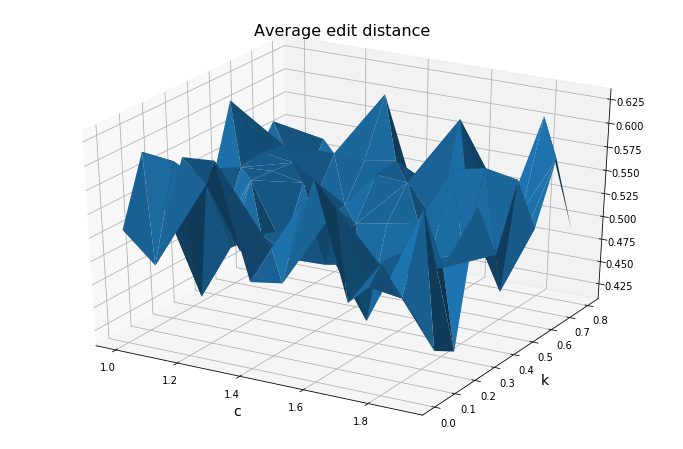

In [17]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')

ax.plot_trisurf(c, k, error, linewidth=0.2)
ax.set_ylabel('k', fontsize=14, labelpad=7)
ax.set_xlabel('c', fontsize=14, labelpad=7)
plt.title('Average edit distance', fontsize=16)
plt.show()

In [21]:
%matplotlib qt

cm = ['red','blue','green','magenta','cyan','orange','grey']
dim_num = [0 if x=='x' else 1 if x=='y' else 2 if x=='z' else 3 if x=='xy' else 4 if x=='xz' else 5 if x=='yz' else 6 for x in dim]

cmap = matplotlib.colors.ListedColormap(cm)

ticks = ['x', 'y', 'z', 'xy', 'xz', 'yz', 'xyz']
norm = matplotlib.colors.BoundaryNorm(ticks, cmap.N)

# create figure, 3d grid, set background to white
fig2 = plt.figure(figsize=(12,8))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax2.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax2.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))

# create plot
img = ax2.scatter(c, k, error, alpha=0.5, s=38, c=dim_num, cmap=cmap)

# set labels
ax2.set_ylabel('parameter k', fontsize=14, labelpad=7)
ax2.set_xlabel('parameter c', fontsize=14, labelpad=7)
ax2.set_zlabel('normalized edit distance', fontsize=14, labelpad=7)
plt.title('Average edit distance (2 steps)', fontsize=16)

# create colorbar
cb = plt.colorbar(img, cax = fig2.add_axes([0.9,0.3,0.03,0.4]))
cb.ax.set_yticklabels(ticks)
plt.show()

In [281]:
# generate rotating image

fig3 = plt.figure(figsize=(12,8))
ax3 = mplot3d.Axes3D(fig3)
ax3.w_xaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.w_yaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.w_zaxis.set_pane_color((1.0,1.0,1.0,1.0))
ax3.set_ylabel('parameter k', fontsize=14, labelpad=7)
ax3.set_xlabel('parameter c', fontsize=14, labelpad=7)
ax3.set_zlabel('normalized edit distance', fontsize=14, labelpad=7)

def init():
    ax3.scatter(c, k, error, alpha=0.5, s=38, c=dim_num, cmap=cmap)
    
    return fig,

def animate(i):
    ax3.view_init(elev=10, azim=i*4)
    return fig,

animated = animation.FuncAnimation(fig3, animate, init_func=init, frames=90, interval=50, blit=True)

In [284]:
# save animated fig

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

fig_name = 'rotate_model_lowesterror_3D'
#animated.save(fig_name+'.gif', writer='imagemagick', fps=1000/50)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=5, bitrate=10000)
animated.save(fig_name+'.mp4', writer=writer)